In [20]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [4]:
DATA_DIR='D:/Users/amira/Documents/datasets/emotions/zoom'

In [5]:
import os
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn import svm,metrics,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import pairwise_distances

from collections import defaultdict
import os
import random
import numpy as np
from tqdm import tqdm
import time
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
compare_filenames=lambda x: int(os.path.splitext(x)[0])

In [18]:
video_path=os.path.normpath(os.path.join(DATA_DIR,'videos/4.mp4'))
print(video_path)
faces_path=os.path.normpath(os.path.join(DATA_DIR,'faces'))

D:\Users\amira\Documents\datasets\emotions\zoom\videos\4.mp4


# Face detection + OCR

In [21]:
import tensorflow as tf

print(tf.__version__)
from tensorflow.compat.v1.keras.backend import set_session 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.compat.v1.Session(config=config)
set_session(sess)

from facial_analysis import FacialImageProcessing
imgProcessing=FacialImageProcessing(False)

2.8.0


In [22]:
import numpy as np
import cv2
import math
from skimage import transform as trans
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : array
        order: {'x1', 'y1', 'x2', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : array
        order: {'x1', 'y1', 'x2', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    return iou

#print(get_iou([10,10,20,20],[15,15,25,25]))

def preprocess(img, bbox=None, landmark=None, **kwargs):
    M = None
    image_size = [224,224]
    src = np.array([
      [30.2946, 51.6963],
      [65.5318, 51.5014],
      [48.0252, 71.7366],
      [33.5493, 92.3655],
      [62.7299, 92.2041] ], dtype=np.float32 )
    if image_size[1]==224:
        src[:,0] += 8.0
    src*=2
    if landmark is not None:
        dst = landmark.astype(np.float32)

        tform = trans.SimilarityTransform()
        #dst=dst[:3]
        #src=src[:3]
        #print(dst.shape,src.shape,dst,src)
        tform.estimate(dst, src)
        M = tform.params[0:2,:]
        #M = cv2.estimateRigidTransform( dst.reshape(1,5,2), src.reshape(1,5,2), False)
        #print(M)

    if M is None:
        if bbox is None: #use center crop
            det = np.zeros(4, dtype=np.int32)
            det[0] = int(img.shape[1]*0.0625)
            det[1] = int(img.shape[0]*0.0625)
            det[2] = img.shape[1] - det[0]
            det[3] = img.shape[0] - det[1]
        else:
              det = bbox
        margin = 0#kwargs.get('margin', 44)
        bb = np.zeros(4, dtype=np.int32)
        bb[0] = np.maximum(det[0]-margin//2, 0)
        bb[1] = np.maximum(det[1]-margin//2, 0)
        bb[2] = np.minimum(det[2]+margin//2, img.shape[1])
        bb[3] = np.minimum(det[3]+margin//2, img.shape[0])
        ret = img[bb[1]:bb[3],bb[0]:bb[2],:]
        if len(image_size)>0:
              ret = cv2.resize(ret, (image_size[1], image_size[0]))
        return ret 
    else: #do align using landmark
        assert len(image_size)==2
        warped = cv2.warpAffine(img,M,(image_size[1],image_size[0]), borderValue = 0.0)
        return warped

In [23]:
import pytesseract

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

if not os.path.exists(faces_path):
    os.mkdir(faces_path)

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print('total_frames:',total_frames)
cap.set(cv2.CAP_PROP_POS_FRAMES,1)

frame_count = 0
counter=0
bboxes,all_text=[],[]

for frame_count in tqdm(range(total_frames-1)):
    ret, frame_bgr = cap.read()
    counter+=1
    if not ret:
        #cap.release()
        #break
        continue
    frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    bounding_boxes, points = imgProcessing.detect_faces(frame)
    points = points.T
    if len(bounding_boxes)!=0:
        sorted_indices=bounding_boxes[:,0].argsort()
        bounding_boxes=bounding_boxes[sorted_indices]
        points=points[sorted_indices]

        faces_folder=os.path.join(faces_path, str(counter)) 
        if not os.path.exists(faces_folder):
            os.mkdir(faces_folder)
        for i,b in enumerate(bounding_boxes):
            outfile=os.path.join(faces_folder, str(i)+'.png')
            if not os.path.exists(outfile):
                if True:
                    p=None
                else:
                    p=points[i]
                    p = p.reshape((2,5)).T
                face_img=preprocess(frame_bgr,b,p)

                if np.prod(face_img.shape)==0:
                    print('Empty face ',b,' found for ',filename)
                    continue
                cv2.imwrite(outfile, face_img) 
        bboxes.append(bounding_boxes)
        
        frame = cv2.resize(frame, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_LINEAR)
        results=pytesseract.image_to_data(frame,lang='rus+eng',output_type=pytesseract.Output.DICT)
        frame_text=[]
        for i in range(0, len(results["text"])):
            x = results["left"][i]
            y = results["top"][i]
            w = results["width"][i]
            h = results["height"][i]
            text = results["text"][i].strip()
            conf = float(results["conf"][i])
            if conf > 0 and len(text)>1:
                frame_text.append((text,int(x/frame.shape[1]*frame_bgr.shape[1]),int(y/frame.shape[0]*frame_bgr.shape[0]),
                                 int(w/frame.shape[1]*frame_bgr.shape[1]),int(h/frame.shape[0]*frame_bgr.shape[1])))
        all_text.append(frame_text)
    
cap.release()    

total_frames: 1701


100%|██████████| 1700/1700 [19:36<00:00,  1.44it/s]


## Text processing 

In [24]:
def combine_words(photo_text):
    #print(photo_text)
    if len(photo_text)>0:
        new_text=[photo_text[0]]
        for word_ind in range(1,len(photo_text)):
            prev_text,x1,y1,w1,h1=new_text[-1]
            center1_x,center1_y=x1+w1,y1+h1/2
            cur_text,x2,y2,w2,h2=photo_text[word_ind]
            center2_x,center2_y=x2,y2+h2/2
            dist=abs(center1_x-center2_x)+abs(center1_y-center2_y)
            #print(prev_text,cur_text,dist)
            if dist>=7: #0.01:
                new_text.append(photo_text[word_ind])
            else:
                new_text[-1]=(prev_text+' '+cur_text,x1,y1,x2+w2-x1,y2+h2-y1)
    else:
        new_text=[]
    return new_text

In [25]:
def get_closest_texts(bboxes,photo_text):
    best_texts,best_distances=[],[]
    for (x1,y1,x2,y2,_) in bboxes:
        face_x,face_y=x1,y2
        #print(x1,y1,x2,y2)
        best_dist=10000
        best_text=''
        for (text,x,y,w,h) in photo_text:
            if y>y1:
                dist_y=abs(face_y-y)
                if face_x<x:
                    dist_x=x-face_x
                elif face_x>x+w:
                    dist_x=face_x-x-w
                else:
                    dist_x=0
                #print(text,dist_x, dist_y,x,y,w,h)
                if dist_x<best_dist and dist_y<1.5*(y2-y1):
                    best_dist=dist_x
                    best_text=text
        #print(best_text,best_dist,(x2-x1))
        if best_dist>=(x2-x1)*2:
            best_text=''
        if best_text!='':
            for i,prev_txt in enumerate(best_texts):
                if prev_txt==best_text:
                    if best_distances[i]<best_dist:
                        best_text=''
                        break
                    else:
                        best_texts[i]=''
        best_texts.append(best_text)
        best_distances.append(best_dist)
    return best_texts

# FaceId 

In [26]:
import torch
from PIL import Image
from torchvision import datasets, transforms

print(f"Torch: {torch.__version__}")
device = 'cuda'

Torch: 1.10.2+cu113


In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
torch.cuda.is_available()

True

In [14]:
import timm
model=timm.create_model('tf_efficientnet_b0_ns', pretrained=False)
model.classifier=torch.nn.Identity()
model.load_state_dict(torch.load('D:/Users/amira/Desktop/Course Work/models/pretrained_faces/state_vggface2_enet0_new.pt'))

model=model.to(device)
model.eval()

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): Sequential(
      (0

In [28]:
test_transforms = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

In [29]:
embeddings=[]
i=0
for filename in tqdm(sorted(os.listdir(faces_path), key=compare_filenames)):
    faces_dir=os.path.join(faces_path,filename)
    imgs=[]
    for img_name in sorted(os.listdir(faces_dir), key=compare_filenames):
        img = Image.open(os.path.join(faces_dir,img_name))
        img_tensor = test_transforms(img)
        imgs.append(img_tensor)

    if len(imgs)>0:        
        scores = model(torch.stack(imgs, dim=0).to(device))
        scores=scores.data.cpu().numpy()
    else:
        scores=[]

    embeddings.append(scores)
    if len(scores)!=len(bboxes[i]):
        print('Error',videoname,filename,i,len(scores),len(bboxes[i]))
    i+=1

print(len(embeddings))

100%|██████████| 1650/1650 [01:11<00:00, 23.19it/s]

1650


## Faces only 

In [30]:
face_files=[]
subjects=None
X_recent_features=None
for i,filename in enumerate(sorted(os.listdir(faces_path), key=compare_filenames)):
    f=preprocessing.normalize(embeddings[i],norm='l2')
    if X_recent_features is None:
        for face_ind in range(len(f)):
            face_files.append([(i,filename,face_ind)])
        X_recent_features=f
    else:
        dist_matrix=pairwise_distances(f,X_recent_features)
        sorted_indices=dist_matrix.argsort(axis=1)
        for face_ind,sorted_inds in enumerate(sorted_indices):
            closest_ind=sorted_inds[0]
            min_dist=dist_matrix[face_ind][closest_ind]
            if min_dist<0.85 or (len(sorted_inds)>1 and min_dist<dist_matrix[face_ind][sorted_inds[1]]-0.1):
                X_recent_features[closest_ind]=f[face_ind]
                face_files[closest_ind].append((i,filename,face_ind))
            else:
                face_files.append([(i,filename,face_ind)])
                X_recent_features=np.concatenate((X_recent_features,[f[face_ind]]),axis=0)
print(len(face_files), [len(files) for files in face_files])

13 [1650, 341, 959, 420, 449, 920, 430, 608, 3, 78, 32, 93, 60]


## Faces+bboxes

In [31]:
def get_square(bb):
    return abs((bb[2]-bb[0])*(bb[3]-bb[1]))
SQUARE_THRESHOLD=900

In [32]:
face_files=[]
subjects=None
X_recent_features=None
recent_bboxes=[]
for i,filename in enumerate(sorted(os.listdir(faces_path), key=compare_filenames)):
    f=preprocessing.normalize(embeddings[i],norm='l2')
    if X_recent_features is None:
        large_face_indices=[]
        for face_ind in range(len(f)):
            if get_square(bboxes[i][face_ind])>SQUARE_THRESHOLD:
                large_face_indices.append(face_ind)
                recent_bboxes.append(bboxes[i][face_ind])
                face_files.append([(i,filename,face_ind)])
        if len(large_face_indices)>0:
            X_recent_features=f[np.array(large_face_indices)]
        #print(X_recent_features.shape)
        #recent_bboxes=list(deepcopy(bboxes[i]))
    else:
        matched_faces=[]
        for face_ind,face_bbox in enumerate(bboxes[i]):
            closest_ind=-1
            best_iou=0
            for ind, bbox in enumerate(recent_bboxes):
                iou=get_iou(face_bbox,bbox)
                if iou>best_iou:
                    best_iou=iou
                    closest_ind=ind
            if best_iou>0.15:
                d=np.linalg.norm(f[face_ind]-X_recent_features[closest_ind])
                if d<1.0:
                    X_recent_features[closest_ind]=f[face_ind]
                    face_files[closest_ind].append((i,filename,face_ind))
                    recent_bboxes[closest_ind]=bboxes[i][face_ind]
                    matched_faces.append(face_ind)
        if len(matched_faces)<len(bboxes[i]):
            dist_matrix=pairwise_distances(f,X_recent_features)
            sorted_indices=dist_matrix.argsort(axis=1)
            for face_ind,sorted_inds in enumerate(sorted_indices):
                if face_ind in matched_faces or get_square(bboxes[i][face_ind])<=SQUARE_THRESHOLD:
                    continue
                closest_ind=sorted_inds[0]
                min_dist=dist_matrix[face_ind][closest_ind]
                if min_dist<0.85:# or (len(sorted_inds)>1 and min_dist<dist_matrix[face_ind][sorted_inds[1]]-0.1):
                    X_recent_features[closest_ind]=f[face_ind]
                    face_files[closest_ind].append((i,filename,face_ind))
                    recent_bboxes[closest_ind]=bboxes[i][face_ind]
                else:
                    face_files.append([(i,filename,face_ind)])
                    X_recent_features=np.concatenate((X_recent_features,[f[face_ind]]),axis=0)
                    recent_bboxes.append(bboxes[i][face_ind])
                    #print(filename,i,X_recent_features.shape,face_ind,closest_ind,dist_matrix[face_ind][closest_ind])
                    #print(dist_matrix)
print(len(face_files), [len(files) for files in face_files])

11 [1650, 364, 967, 1150, 12, 737, 3, 32, 78, 88, 60]


## Text + faces

In [34]:
import editdistance
def levenstein(txt1,txt2):
    if txt1=='' or txt2=='':
        return 1
    #return editdistance.eval(txt1,txt2)
    return (editdistance.eval(txt1,txt2))/(max(len(txt1),len(txt2)))

def get_name(name2count):
    #print(name2count)
    return max(name2count, key=name2count.get)

In [35]:
face_files=[]
recent_texts=[]
X_recent_features=[]

for i,filename in enumerate(sorted(os.listdir(faces_path), key=compare_filenames)):
    photo_text=combine_words(all_text[i])
    best_texts=get_closest_texts(bboxes[i],photo_text)
    f=preprocessing.normalize(embeddings[i],norm='l2')

    if len(recent_texts)==0:
        for face_ind,txt in enumerate(best_texts):
            if len(txt)>=4:
                recent_texts.append({txt:1})
                face_files.append([(i,filename,face_ind)])
                X_recent_features.append(f[face_ind])
    else:
        for face_ind,txt in enumerate(best_texts):
            if len(txt)>=4:
                closest_ind=-1
                best_d_txt=1
                for ind,recent_text_set in enumerate(recent_texts):
                    d_txt=min([levenstein(txt,recent_text) for recent_text in recent_text_set])
                    if d_txt<best_d_txt:
                        best_d_txt=d_txt
                        closest_ind=ind

                face_dist=np.linalg.norm(X_recent_features[closest_ind]-f[face_ind])
                if (best_d_txt<=0.45 and face_dist<=1.0) or face_dist<=0.8:
                    if txt in recent_texts[closest_ind]:
                        recent_texts[closest_ind][txt]+=1
                    else:
                        recent_texts[closest_ind][txt]=1
                    face_files[closest_ind].append((i,filename,face_ind))
                    X_recent_features[closest_ind]=f[face_ind]
                elif best_d_txt>0.45:
                    recent_texts.append({txt:1})
                    face_files.append([(i,filename,face_ind)])
                    X_recent_features.append(f[face_ind])
                    #print(videoname,filename,i,face_ind,face_dist,txt,best_d_txt,recent_texts[closest_ind])

subjects=[get_name(name2count) for name2count in recent_texts]

---------------

0 1230 (0, '1', 0)
1 475 (14, '15', 1)
2 1230 (19, '20', 1)
3 546 (41, '42', 2)
5 204 (73, '74', 1)


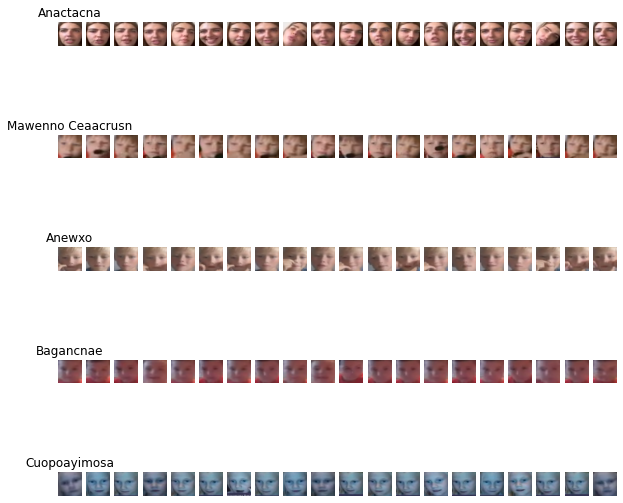

In [36]:
import random
plt_ind=1
minNoPhotos=20
min_num_files=100
no_clusters=len([i for i,files in enumerate(face_files) if len(files)>min_num_files])
plt.figure(figsize=(10,10))
for i,files in enumerate(face_files):
    if len(files)>min_num_files:
        print(i,len(files),files[0])
        for j in range(minNoPhotos):
            f=random.choice(files)
            fpath=os.path.join(faces_path,f[1],str(f[2])+'.png')
            plt.subplot(no_clusters,minNoPhotos,plt_ind)
            if j==0 and subjects is not None:
                plt.title(subjects[i])
            plt.imshow(Image.open(fpath))
            plt.axis('off')
            plt_ind+=1
plt.show()

# Emotions

In [39]:
if False:
    model_name='enet_b2_8'
    IMG_SIZE=260 #224 #
else:
    model_name='enet_b0_8_best_afew'
    IMG_SIZE=224
PATH='D:/Users/amira/Desktop/Course Work/models/affectnet_emotions/'+model_name+'.pt'
test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)
feature_extractor_model = torch.load(PATH)

In [40]:
classifier_weights=feature_extractor_model.classifier[0].weight.cpu().data.numpy()
classifier_bias=feature_extractor_model.classifier[0].bias.cpu().data.numpy()
print(classifier_weights.shape,classifier_weights)
print(classifier_bias.shape,classifier_bias)

(8, 1280) [[ 0.00515123 -0.00972202 -0.01203173 ...  0.05333852 -0.06858566
  -0.12183831]
 [ 0.05973773 -0.01306326 -0.00981904 ...  0.04521868  0.03189689
   0.16130415]
 [-0.02749952 -0.1972647   0.02720864 ...  0.18251328 -0.03125019
  -0.07623435]
 ...
 [-0.15567695  0.09653756 -0.02194299 ... -0.07001057  0.00730149
   0.11114535]
 [ 0.08313771 -0.16218805 -0.10610525 ... -0.05499801 -0.00550514
   0.12355816]
 [-0.04981646  0.23458022 -0.16780637 ... -0.24049994  0.02247157
  -0.10648516]]
(8,) [-0.02634053  0.05532073 -0.09343545  0.01225835  0.05623824  0.05436933
 -0.0242617   0.02030101]


In [41]:
feature_extractor_model.classifier=torch.nn.Identity()
feature_extractor_model.eval()

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): Sequential(
      (0

In [42]:
def get_probab(features):
    x=np.dot(features,np.transpose(classifier_weights))+classifier_bias
    #print(x)
    e_x = np.exp(x - np.max(x,axis=0))
    return e_x / e_x.sum(axis=1)[:,None]

In [43]:
if len(classifier_bias)==7:
    idx_to_class={0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Neutral', 5: 'Sadness', 6: 'Surprise'}
    INTERESTING_STATES=[0,1,2,3,6]
else:
    idx_to_class={0: 'Anger', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happiness', 5: 'Neutral', 6: 'Sadness', 7: 'Surprise'}
    INTERESTING_STATES=[0,2,3,4,7]
print(idx_to_class)

{0: 'Anger', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happiness', 5: 'Neutral', 6: 'Sadness', 7: 'Surprise'}


In [44]:
X_global_features,X_scores=[],[]
for filename in tqdm(sorted(os.listdir(faces_path), key=compare_filenames)):
    faces_dir=os.path.join(faces_path,filename)
    imgs=[]
    for img_name in sorted(os.listdir(faces_dir), key=compare_filenames):
        img = Image.open(os.path.join(faces_dir,img_name))
        img_tensor = test_transforms(img)
        if img.size:
            imgs.append(img_tensor)

    if len(imgs)>0:
        features = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
        features=features.data.cpu().numpy()
        scores=get_probab(features)
        #print(videoname,filename,features.shape,scores.shape)
        X_global_features.append(features)
        X_scores.append(scores)

100%|██████████| 1650/1650 [00:46<00:00, 35.38it/s]


# Create gifs 

In [47]:
from IPython import display
from PIL import Image, ImageFont, ImageDraw 
min_num_files=100
unicode_font = ImageFont.truetype("D:/Users/amira/Desktop/Course Work/d9464-arkhip_font.ttf", 8)
gif=[]
no_clusters=len([i for i,files in enumerate(face_files) if len(files)>min_num_files])
for subject_ind,files in enumerate(face_files):
    if len(files)>min_num_files:
        print(len(files),files[0])
        prev_filename_ind=-1
        start_i=0
        current_scores,current_features=[],[]
        current_emotion=-1
        emotion2longest_sequence={}
        for i,(file_ind,filename,face_ind) in enumerate(files):
            filename_ind=int(filename)
            if prev_filename_ind==-1:
                prev_filename_ind=filename_ind-1
            new_emotion=np.argmax(X_scores[file_ind][face_ind])
            #print('check',prev_filename_ind,filename_ind-1, new_emotion,current_emotion)
            if prev_filename_ind!=filename_ind-1 or new_emotion!=current_emotion or new_emotion not in INTERESTING_STATES:
                if len(current_scores)>=10:
                    emotion=np.argmax(np.mean(current_scores,axis=0))
                    if emotion in emotion2longest_sequence:
                        if emotion2longest_sequence[emotion][0]<len(current_scores):
                            emotion2longest_sequence[emotion]=(len(current_scores),start_i,i-1)
                    else:
                        emotion2longest_sequence[emotion]=(len(current_scores),start_i,i-1)
                    #print(start_i,i-1,idx_to_class[emotion])
                start_i=i
                current_scores,current_features=[],[]
            prev_filename_ind=filename_ind
            current_emotion=new_emotion
            current_scores.append(X_scores[file_ind][face_ind])
            current_features.append(X_global_features[file_ind][face_ind])

        if len(emotion2longest_sequence)>0:
            for emotion, (_,start_i, end_i) in emotion2longest_sequence.items():
                print(idx_to_class[emotion],start_i,end_i,len(files))
                for i in range(start_i,min(start_i+20,end_i)+1):
                    #print(files[i])
                    fpath=os.path.join(faces_path,files[i][1],str(files[i][2])+'.png')
                    img=Image.open(fpath)
                    img = img.resize((112,112), Image.ANTIALIAS)
                    draw = ImageDraw.Draw(img) 
                    draw.text((0, 0), subjects[subject_ind], align ="left", font=unicode_font,fill=(0,0,255,255))
                    draw.text((0, 10), idx_to_class[emotion], align ="left",font=unicode_font, fill=(0,255,0,255))
                    gif.append(img.convert("P",palette=Image.ADAPTIVE))

if False:
    for img in gif:
        display.clear_output(wait=True)
        plt.axis('off')
        plt.imshow(img)
        plt.show()
if True and len(gif)>0:
    gif[0].save('emo.gif', save_all=True,optimize=False, append_images=gif[1:],disposal=2)

1230 (0, '1', 0)
Anger 113 138 1230
Disgust 386 400 1230
Happiness 994 1022 1230
475 (14, '15', 1)
Anger 63 82 475
1230 (19, '20', 1)
Fear 151 168 1230
Happiness 182 213 1230
Anger 1072 1093 1230
546 (41, '42', 2)
Happiness 41 50 546
Anger 320 343 546
Surprise 417 428 546
204 (73, '74', 1)


In [49]:
ls

 Volume in drive D has no label.
 Volume Serial Number is B686-429A

 Directory of d:\Users\amira\Desktop\Course Work

28.02.2022  21:45    <DIR>          .
24.02.2022  15:19    <DIR>          ..
28.02.2022  19:27    <DIR>          __pycache__
28.02.2022  18:21            78�232 d9464-arkhip_font.ttf
20.02.2022  21:37         1�017�397 display_emotions.ipynb
28.02.2022  21:45         1�694�987 emo.gif
28.02.2022  19:26            13�730 facial_analysis.py
17.02.2022  15:13            13�729 facial_analysis_for_colab.py
20.02.2022  20:51             5�302 get_faces.ipynb
15.02.2022  20:02             4�821 make_frames_of_singleface.ipynb
28.02.2022  19:15    <DIR>          models
28.02.2022  19:11           256�996 video_summarizer.ipynb
               8 File(s)      3�085�194 bytes
               4 Dir(s)  862�549�069�824 bytes free
